# Classification. Linear models and KNN

In [228]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [229]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Part 1: Implementing Logistic Regression

(2 points) Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes should correspond to {-1, 1} labels.

In [1143]:
from sklearn.exceptions import NotFittedError
from math import e
import math

In [1144]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
   
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.res_loss=[] 
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        self.X=X
        self.weights=weights
        get_mult=self.X*self.weights
        odds=np.sum(get_mult, axis=1)
        res=[]
        for i in odds:
            res.append(1/(1+e**(-i)))
        return res  
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        loss= np.mean(np.log(1+np.exp**(-np.dot(x,weights)*y)))+(1/(2*self.C))*\
        np.amin((np.linalg.norm(self.weights_)**2))
        return loss
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight init
        
        for i in range(self.max_iter):
            delta=self.weights_/self.C -np.sum(X_ext.T*y*(1-1/(1+np.exp(-np.dot(X_ext,self.weights_)* y))),\
                                               axis=1)/y.shape[0]+self.weights_
            self.res_loss.append(np.mean(get_loss(self, X_ext, self.weights_, y )))
            self.weights_ -= self.eta * delta
            
            if i>self.max_iter or np.linalg.norm(self.eta*delta)<self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        res=[]
        for i in self.predict_proba(X):
            if i >0.5:
                res.append(1)
            else:
                res.append(-1)
        return res

In [1145]:
from sklearn import datasets
from sklearn import metrics

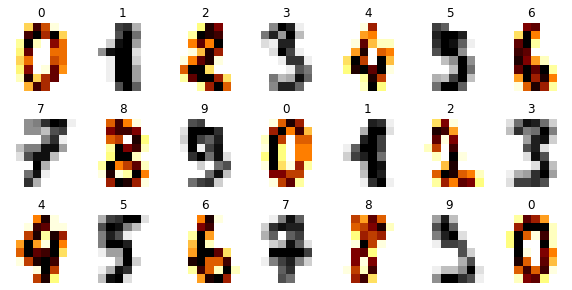

In [1146]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [1147]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [1148]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [1149]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [1150]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [1151]:
lr_clf.fit(X_train, y_train)

In [1152]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [1153]:
model = CustomLogisticRegression()

C:\Users\YK\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


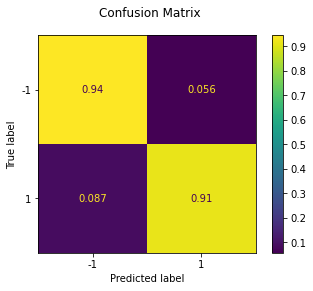

In [1154]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [1155]:
train_acc, test_acc

(0.9039665970772442, 0.9277777777777778)

In [1156]:
assert min(train_acc, test_acc) > 0.9

(0.5 points) Visualize the loss history.

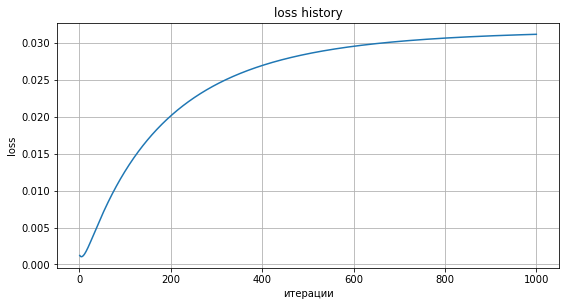

In [1157]:
iters = np.linspace(1, len(model.res_loss),len(model.res_loss) , dtype=int)
plt.figure(figsize=(9, 4.5))
plt.plot(iters, model.res_loss , label='Training')
plt.title('loss history')
plt.xlabel('итерации')
plt.ylabel('loss')
plt.grid(True)
plt.show()

(0.5 points) Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [1158]:
etas=np.linspace(0.00001, 0.1, 1 + 40)
train, test=[],[]
for i in etas:
    model = CustomLogisticRegression(eta=i)
    model.fit(X_train, y_train)
    train.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    test.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))

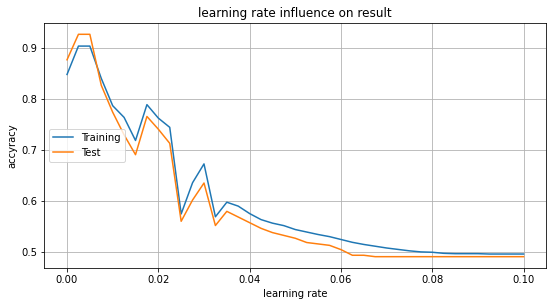

In [1159]:
plt.figure(figsize=(9, 4.5))
plt.plot(etas, train, label='Training')
plt.plot(etas, test, color='C1', label='Test')
plt.title("learning rate influence on result")
plt.xlabel('learning rate')
plt.ylabel('accyracy')
plt.grid(True) 
plt.legend(loc='center left') 
plt.show()
    

Вывод: с увеличением коэффициента скорости обучения точность снижается одинаково и в тесте, и в трейне

(0.5 points) Try different regularization parameter values and compare the model quality.

In [1160]:
cas=np.linspace(0.01, 100, 1 + 40)
train1, test1=[],[]
for i in etas:
    model = CustomLogisticRegression(C=i)
    model.fit(X_train, y_train)
    train1.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    test1.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))

C:\Users\YK\AppData\Local\Temp/ipykernel_17224/483514495.py:47: RuntimeWarning: overflow encountered in exp
  delta=self.weights_/self.C -np.sum(X_ext.T*y*(1-1/(1+np.exp(-np.dot(X_ext,self.weights_)* y))),\
C:\Users\YK\AppData\Local\Temp/ipykernel_17224/1315992229.py:4: RuntimeWarning: overflow encountered in exp
  return (np.log(1+np.exp(-np.dot(x,self.weights_)*y))/len(y)+1/(2*self.C)\
C:\Users\YK\AppData\Local\Temp/ipykernel_17224/1315992229.py:4: RuntimeWarning: overflow encountered in double_scalars
  return (np.log(1+np.exp(-np.dot(x,self.weights_)*y))/len(y)+1/(2*self.C)\
C:\Users\YK\AppData\Local\Temp/ipykernel_17224/483514495.py:47: RuntimeWarning: overflow encountered in true_divide
  delta=self.weights_/self.C -np.sum(X_ext.T*y*(1-1/(1+np.exp(-np.dot(X_ext,self.weights_)* y))),\


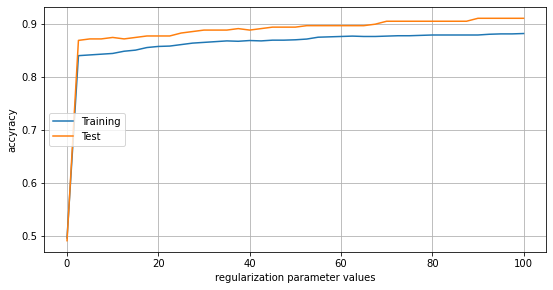

In [1161]:
plt.figure(figsize=(9, 4.5))
plt.plot(cas, train1, label='Training')
plt.plot(cas, test1, color='C1', label='Test')
plt.xlabel('regularization parameter values')
plt.ylabel('accyracy')
plt.grid(True)  
plt.legend(loc='center left') 
plt.show()

выводы: с увеличением силы регуляризации точность предсказания растет

(0.5 points) Compare zero initialization and random initialization.

C:\Users\YK\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


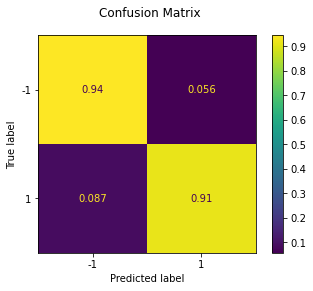

In [1162]:
model1 = CustomLogisticRegression(zero_init=True)
train_acc1, test_acc1 = fit_evaluate(model1, X_train, y_train, X_test, y_test)

In [1163]:
train_acc1, test_acc1

(0.9039665970772442, 0.9277777777777778)

при нулевой инициализации особо ничего не поменялось

# Part 3: Synthetic Titanic Survival Prediction

In [1167]:
PATH = ".\\"

In [1173]:
data = pd.read_csv(os.path.join(PATH,"train.csv.zip"))

In [1174]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


# EDA


(0.5 points) How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [1176]:
sex=data.groupby('Sex', as_index=False).agg({'PassengerId':'count'}).rename(columns={'PassengerId':'number'})
sex

,Sex,number
0,female,43886
1,male,56114


,Survived,number,percentage
0,0,57226,0.57226
1,1,42774,0.42774


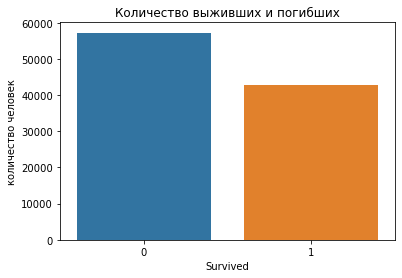

In [1177]:
survived=data.groupby('Survived', as_index=False).agg({'PassengerId':'count'}).rename(columns={'PassengerId':'number'})
plt.title("Количество выживших и погибших")
sns.barplot(x=survived.Survived, y=survived['number'])
plt.ylabel("количество человек")
survived['percentage']=survived.number/100000
survived

,Sex,Survived,number,total,percentage
0,female,0,12660,43886,0.288475
1,female,1,31226,43886,0.711525
2,male,0,44566,56114,0.794205
3,male,1,11548,56114,0.205795


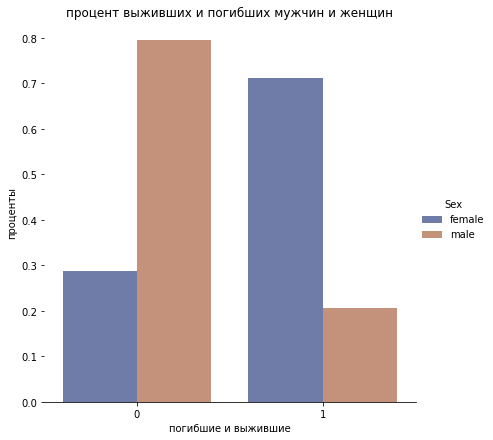

In [1178]:
sex=data.groupby(['Sex'], as_index=False).agg({'PassengerId':'count'})\
    .rename(columns={'PassengerId':'number'})
sex_survived=data.groupby(['Sex','Survived'], as_index=False).agg({'PassengerId':'count'})\
    .rename(columns={'PassengerId':'number'})
sex_survived=sex_survived.merge(sex, on='Sex').rename(columns={'number_x':'number', 'number_y':'total'})
sex_survived['percentage']=sex_survived.number/sex_survived.total
sex_survived
g = sns.catplot(
    data=sex_survived, kind="bar",
    x="Survived", y="percentage", hue="Sex",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("погибшие и выжившие", "проценты")
plt.title("процент выживших и погибших мужчин и женщин")
sex_survived

да, есть связь между выжившими и погибшими. У женщин вероятность выжить больше

(0.5 points) Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

,Age,number
0,0.08,39
1,0.17,67
2,0.25,68
3,0.33,53
4,0.42,62
...,...,...
168,83.00,9
169,84.00,3
170,85.00,4
171,86.00,2


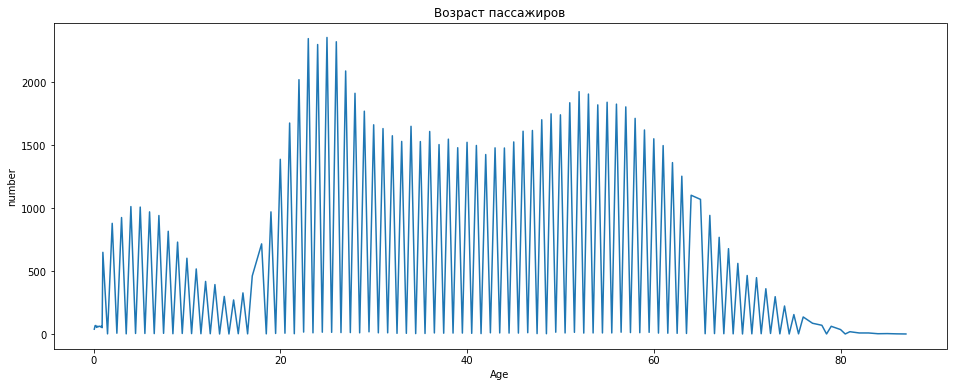

In [1179]:
titanic_age=data.groupby('Age', as_index=False).agg({'PassengerId':'count'})\
    .rename(columns={'PassengerId':'number'})
titanic_age
plt.figure(figsize=(16,6))
plt.title("Возраст пассажиров")
sns.lineplot(data=titanic_age, x="Age", y="number")
titanic_age

,Survived,Age
0,0,36.708695
1,1,40.553799


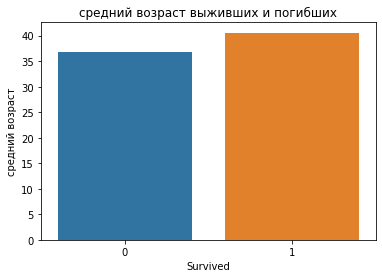

In [1180]:
average_age=data.groupby('Survived',as_index=False).agg({'Age':'mean'})
plt.title("средний возраст выживших и погибших")
sns.barplot(x=average_age.Survived, y=average_age['Age'])
plt.ylabel("средний возраст")
average_age

,Survived,Age
0,0,36.0
1,1,43.0


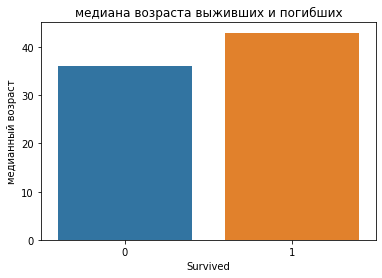

In [1181]:
median_age=data.groupby('Survived',as_index=False).agg({'Age':'median'})
plt.title("медиана возраста выживших и погибших")
sns.barplot(x=median_age.Survived, y=median_age['Age'])
plt.ylabel("медианный возраст")
median_age

средний и медианный возраст различаются среди выживших и погибших. Вполне возможно, что больше пожилых людей было в первом классе, где выживали чаще

(1 point) Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

,Pclass,all_number
0,1,30315
1,2,28679
2,3,41006


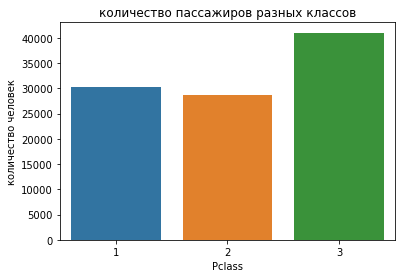

In [1182]:
classes=data.groupby('Pclass', as_index=False).agg({'PassengerId':'count'}).rename(columns={'PassengerId':'all_number'})
plt.title("количество пассажиров разных классов")
sns.barplot(x=classes.Pclass, y=classes['all_number'])
plt.ylabel("количество человек")
classes

,Pclass,Survived,all_number,percentage_survive
0,1,17576,30315,0.579779
1,2,15057,28679,0.525018
2,3,10141,41006,0.247305


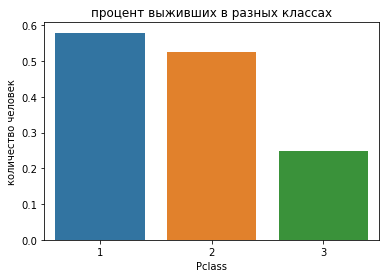

In [1183]:
classes_survived=data.groupby('Pclass', as_index=False).agg({'Survived':'sum'})
classes_survived=classes_survived.merge(classes,on='Pclass')
classes_survived['percentage_survive']=classes_survived.Survived/classes_survived.all_number
plt.title("процент выживших в разных классах")
sns.barplot(x=classes_survived.Pclass, y=classes_survived['percentage_survive'])
plt.ylabel("количество человек")
classes_survived

,Embarked,total,Survived,count,percentage
0,C,22187,0,5518,0.248704
1,C,22187,1,16669,0.751296
2,Q,5424,0,2186,0.403024
3,Q,5424,1,3238,0.596976
4,S,72139,0,49394,0.684706
5,S,72139,1,22745,0.315294


<Figure size 1296x720 with 0 Axes>

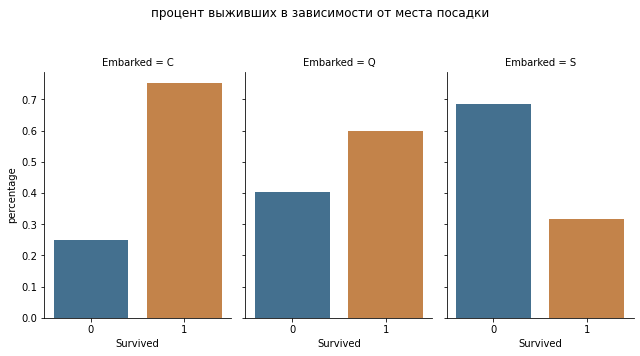

In [1184]:
emb_total=data.groupby('Embarked', as_index=False).agg({'PassengerId':'count'})\
    .rename(columns={'PassengerId':'total'})
emb_sur=data.groupby(['Embarked','Survived'], as_index=False).agg({'PassengerId':'count'})\
    .rename(columns={'PassengerId':'count'})
emb_sur=emb_total.merge(emb_sur, on='Embarked')
emb_sur["percentage"]=emb_sur['count']/emb_sur.total
plt.figure(figsize=(18,10))
g7 = sns.catplot(x="Survived", y="percentage", col="Embarked",
               data=emb_sur, saturation=.5,
               kind="bar", ci=None, aspect=.6)
g7.fig.subplots_adjust(top=.8)
g7.fig.suptitle('процент выживших в зависимости от места посадки')
emb_sur

Самый безопасный класс это первый. Немного отстает второй. Больше людей выжило, кто садился на корабль в Cherbourg, причем людей первого и второго класса там садилось не 
больше, чем в других портах, непонятно, с чем это связано

# Modelling

(0.5 points) Find the percentage of missing values for each feature.

Cabin          0.67866
Ticket         0.04623
Age            0.03292
Embarked       0.00250
Fare           0.00134
PassengerId    0.00000
Survived       0.00000
Pclass         0.00000
Name           0.00000
Sex            0.00000
SibSp          0.00000
Parch          0.00000
dtype: float64

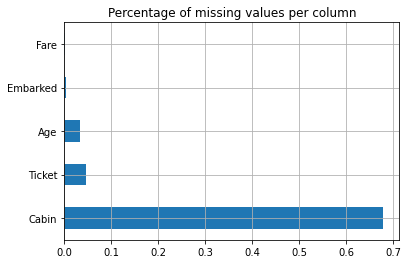

In [1185]:

missing_percentage = data.isna().sum().sort_values(ascending=False) / len(data)
missing_columns = missing_percentage[missing_percentage != 0]
missing_columns.plot(kind='barh', title='Percentage of missing values per column', grid=True)
missing_percentage

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

для возраста и стоимости пропущенные значения можно заполнить средним или медианой. для номера каюты наверное сделать ничего не получится и лучше просто не использовать эту колонку в предсказаниях, тем более что она не очень и важна.. Место посадки и билет можно заменить модой. Недостатки везде одинаковы, это просто будут значения, которые вероятнее всего могли бы там быть, а могли и не быть. Из преимуществ - довольно быстро так можно заполнить пропуски

(1.5 points) Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!


In [1186]:
#замещение NaN 
data.Age=data.Age.fillna(data.Age.mean())
data.Fare=data.Fare.fillna(data.Fare.mean())
data.Ticket=data.Ticket.fillna(data.Ticket.mode())
data.Embarked=data.Embarked.fillna(data.Embarked.mode())
data.drop(columns='Cabin', inplace=True)


In [1187]:
def change_sex(x):
    if x=='male':
        return 1
    else:
        return 0
data['Sex'] = data['Sex'].apply(change_sex)    

In [1188]:
def change_emb(x):
    if x=='S':
        return 1
    elif x=='C':
        return 0
    else:
        return 2
data['Embarked']=data['Embarked'].apply(change_emb)  

In [1189]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,1,1,"Oconnor, Frankie",1,38.355472,2,0,209245,27.14,1
1,1,0,3,"Bryan, Drew",1,38.355472,0,0,27323,13.35,1
2,2,0,3,"Owens, Kenneth",1,0.330000,1,2,CA 457703,71.29,1
3,3,0,3,"Kramer, James",1,19.000000,0,0,A. 10866,13.04,1
4,4,1,3,"Bond, Michael",1,25.000000,0,0,427635,7.76,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",0,62.000000,0,0,PC 15008,14.86,0
99996,99996,0,2,"Brown, Herman",1,66.000000,0,0,13273,11.15,1
99997,99997,0,3,"Childress, Charles",1,37.000000,0,0,NaN,9.95,1
99998,99998,0,3,"Caughlin, Thomas",1,51.000000,0,1,458654,30.92,1


In [1190]:
feature_names=['Sex', 'Age', 'Pclass', 'Embarked']
target='Survived'

x = data[feature_names]
y = data[target]

In [1191]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [1192]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model = LogisticRegression(max_iter=5000,C=500.0, random_state=0)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print(scores.mean())

0.7572857142857143


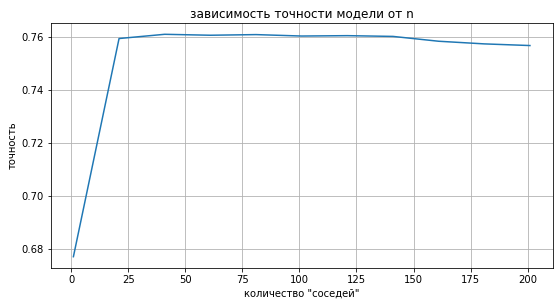

In [1193]:
NEIGHBOURS = np.linspace(1, 201, 11, dtype=int)
from sklearn.neighbors import KNeighborsClassifier
res=[]
for n in NEIGHBOURS:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    res.append(scores.mean())
plt.figure(figsize=(9, 4.5))
plt.plot(NEIGHBOURS, res, label='Training')
plt.title('зависимость точности модели от n')
plt.xlabel('количество "соседей"')
plt.ylabel('точность')
plt.grid(True)
plt.show()
       

(0.5 + X points) Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [1196]:
knn1 = KNeighborsClassifier(n_neighbors=25, weights='distance')
scores1 = cross_val_score(knn1, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores1.mean()

0.7594428571428572

In [1212]:
knn2 = KNeighborsClassifier(n_neighbors=25, weights='distance', algorithm='kd_tree')
scores2 = cross_val_score(knn2, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores2.mean()

0.7583285714285715

In [1228]:
feature_names2=['Sex', 'Pclass', 'Embarked']
target2='Survived'

x = data[feature_names2]
y = data[target2]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [1229]:
knn3 = KNeighborsClassifier(n_neighbors=25, weights='distance', algorithm='kd_tree')
scores3 = cross_val_score(knn3, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores3.mean()

0.7633142857142857

In [1230]:
model4 = LogisticRegression(max_iter=5000,C=500.0, random_state=0, penalty='none')
scores4 = cross_val_score(model4, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(scores4.mean())

0.7569857142857144


In [1231]:
knn3.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=25, weights='distance')

In [1267]:
PATH = ".\\"

In [1268]:
data_test = pd.read_csv(os.path.join(PATH,"test.csv.zip"))

In [1269]:
data_test['Sex'] = data_test['Sex'].apply(change_sex) 
data_test['Embarked']=data_test['Embarked'].apply(change_emb)  

In [1270]:
data_test [feature_names2]

,Sex,Pclass,Embarked
0,1,3,1
1,0,3,1
2,0,1,0
3,1,2,1
4,0,1,0
...,...,...,...
99995,0,3,2
99996,1,1,1
99997,1,3,1
99998,0,1,0


In [1271]:
result= pd.DataFrame(knn3.predict(data_test[feature_names])).rename(columns={0:'Survived'})
result

,Survived
0,0
1,1
2,1
3,0
4,1
...,...
99995,1
99996,0
99997,0
99998,1


In [1272]:
res1=data_test['PassengerId'].to_frame()
res1

,PassengerId
0,100000
1,100001
2,100002
3,100003
4,100004
...,...
99995,199995
99996,199996
99997,199997
99998,199998


In [1273]:
result2 = pd.concat([res1, result], axis=1)

In [1274]:
result2

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1


In [1276]:
final=result2.set_index('PassengerId')

In [1277]:
final

,Survived
PassengerId,
100000,0
100001,1
100002,1
100003,0
100004,1
...,...
199995,1
199996,0
199997,0


In [1280]:
final.to_csv('final.csv')
